<a href="https://colab.research.google.com/github/Aswani-ReddyKV/Melanoma_Detection/blob/main/Aswani_Reddy_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### 1. Data Reading/Data Understanding

#### Importing all the important libraries

In [3]:
!pip install Augmentor
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import Augmentor
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [4]:
# # Defining the path for train and test images
# ## Paths of train and test dataset on local path

# data_dir_train = pathlib.Path("CNN_assignment/Train")
# data_dir_test = pathlib.Path("CNN_assignment/Test")

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
rootfolder = '/content/drive/MyDrive/Colab Notebooks/SkinCancer_Data'
train_dir = pathlib.Path(rootfolder + '/Train')
test_dir = pathlib.Path(rootfolder + '/Test')

In [7]:
image_count_train = len(list(train_dir.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(test_dir.glob('*/*.jpg')))
print(image_count_test)

2239
118


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### 2. Dataset Creation

Create train & validation dataset from the train directory with a batch size of 32. Also, make sure you resize your images to 180*180

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### 3. Dataset visualisation
Create a code to visualize one instance of all the nine classes present in the dataset

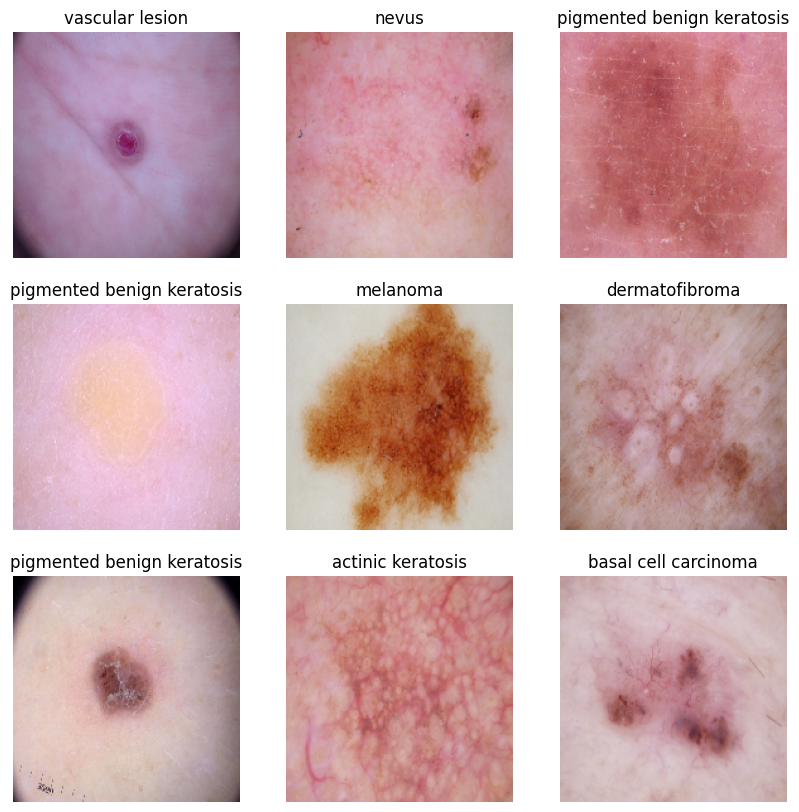

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 4. Model Building & training
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
def model_accfortrainval(model):
    loss, accuracy = model.evaluate(train_ds, verbose=1,)
    loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

    print("Accuracy: ", accuracy)
    print("Validation Accuracy: ",accuracy_v)
    print("Loss: ",loss)
    print("Validation Loss", loss_v)

In [15]:
# Number of target labels
target_labels = 9

model_1 = Sequential([
  layers.Rescaling(1.0/255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Compile the model
Choose an appropirate optimiser and loss function for model training

In [16]:
model_1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

#### Train the model

In [18]:
%%time
epochs = 20
history = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 62s 224ms/step - accuracy: 0.2103 - loss: 2.1666 - val_accuracy: 0.2371 - val_loss: 1.9244
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3524 - loss: 1.7839 - val_accuracy: 0.4161 - val_loss: 1.5725
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4725 - loss: 1.4886 - val_accuracy: 0.3579 - val_loss: 1.7539
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4776 - loss: 1.4630 - val_accuracy: 0.5145 - val_loss: 1.3718
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5404 - loss: 1.2902 - val_accuracy: 0.5257 - val_loss: 1.3597
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5821 - loss: 1.1933 - val_accuracy: 0.5257 - val_loss: 1.4128
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6290 - loss: 1.0943 - val_accuracy: 0.5280 - val_loss: 1.4267
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6372 - loss: 1.0353 - val_accuracy: 0.5190 - val_lo

#### Visualizing training results

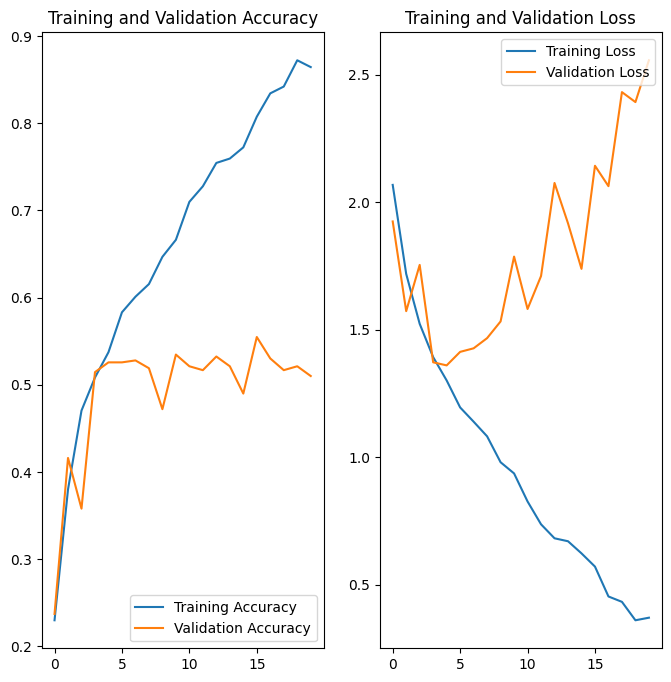

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
model_accfortrainval(model_1)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8663 - loss: 0.3371
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5405 - loss: 2.3834
Accuracy:  0.8705357313156128
Validation Accuracy:  0.5100671052932739
Loss:  0.33303576707839966
Validation Loss 2.556615114212036


#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit

#### Write your findings here

***Observations:***

1. There significant difference between the training accuracy(87%) and validation accuracy(51%)

2. The above data suggests model is overfitting.

3. The Training Loss (0.333) is much lower than the Validation Loss (2.56).

### 5. Chose an appropriate data augmentation strategy to resolve underfitting/overfitting

In [21]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
augmentation_data = keras.Sequential([
                                      layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
                                      layers.RandomRotation(0.3),
                                      layers.RandomZoom(0.1),
                                      layers.RandomContrast(0.1),
])

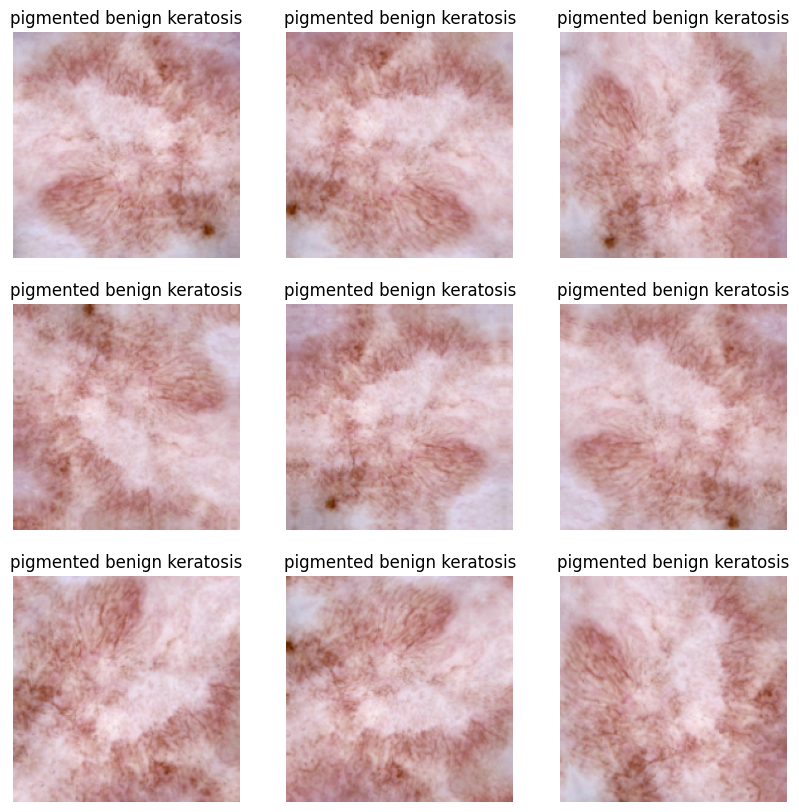

In [22]:
# Visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

### 6. Model Building & training on the augmented data


In [23]:
model_2 = Sequential([
  augmentation_data,
  layers.Rescaling(1.0/255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

#### Compiling the model

In [24]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
# View the summary of all layers
model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### Training the model

In [26]:
%%time
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1522 - loss: 3.0059 - val_accuracy: 0.2013 - val_loss: 2.0240
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2402 - loss: 1.9241 - val_accuracy: 0.4273 - val_loss: 1.6820
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4250 - loss: 1.6336 - val_accuracy: 0.3870 - val_loss: 1.6935
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4155 - loss: 1.6139 - val_accuracy: 0.3960 - val_loss: 1.6670
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4296 - loss: 1.5745 - val_accuracy: 0.4720 - val_loss: 1.5471
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4596 - loss: 1.5214 - val_accuracy: 0.4698 - val_loss: 1.5078
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4808 - loss: 1.4426 - val_accuracy: 0.5078 - val_loss: 1.4838
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5119 - loss: 1.3929 - val_accuracy: 0.4989 - val_loss

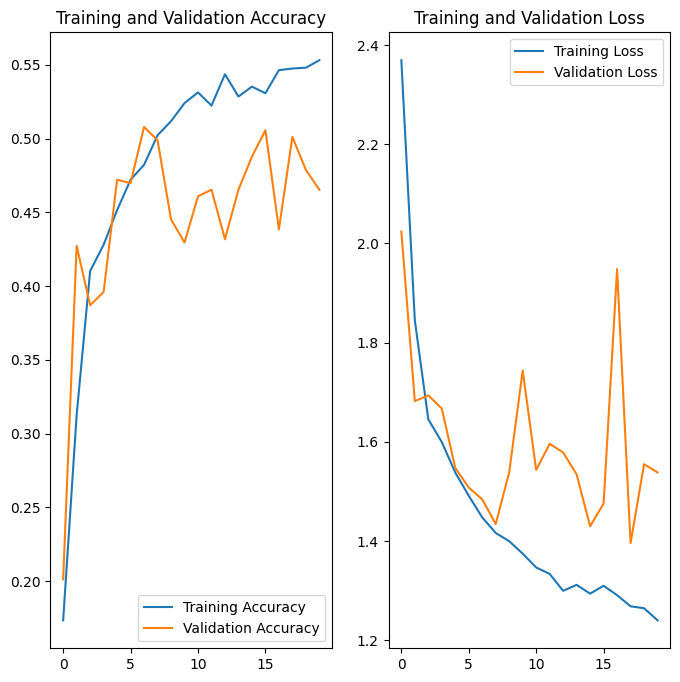

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
model_accfortrainval(model_2)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5030 - loss: 1.4251
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4870 - loss: 1.4795
Accuracy:  0.4832589328289032
Validation Accuracy:  0.46532437205314636
Loss:  1.4510595798492432
Validation Loss 1.5382059812545776


#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

***Observations:***

1. The model's training and validation accuracy are relatively close, and the losses are also somewhat similar.

2. Though both accuracy values are low, and the loss values are relatively high.

3. Model likely needs more complexity (or better hyperparameters) to improve its performance and avoid underfitting.

### 7. Class distribution
#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [29]:
## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(train_dir, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(train_dir, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [30]:
# Extract image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('/content/drive/MyDrive/Colab Notebooks/SkinCancer_Data/Train/actinic keratosis/ISIC_0030133.jpg', 'actinic keratosis'), ('/content/drive/MyDrive/Colab Notebooks/SkinCancer_Data/Train/actinic keratosis/ISIC_0028820.jpg', 'actinic keratosis'), ('/content/drive/MyDrive/Colab Notebooks/SkinCancer_Data/Train/actinic keratosis/ISIC_0028941.jpg', 'actinic keratosis'), ('/content/drive/MyDrive/Colab Notebooks/SkinCancer_Data/Train/actinic keratosis/ISIC_0030408.jpg', 'actinic keratosis'), ('/content/drive/MyDrive/Colab Notebooks/SkinCancer_Data/Train/actinic keratosis/ISIC_0027896.jpg', 'actinic keratosis')]


In [31]:
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,/content/drive/MyDrive/Colab Notebooks/SkinCan...,actinic keratosis
1,/content/drive/MyDrive/Colab Notebooks/SkinCan...,actinic keratosis
2,/content/drive/MyDrive/Colab Notebooks/SkinCan...,actinic keratosis
3,/content/drive/MyDrive/Colab Notebooks/SkinCan...,actinic keratosis
4,/content/drive/MyDrive/Colab Notebooks/SkinCan...,actinic keratosis


In [32]:
## Inspecting the distribution of classes in the data
lesions_df[['Label']].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


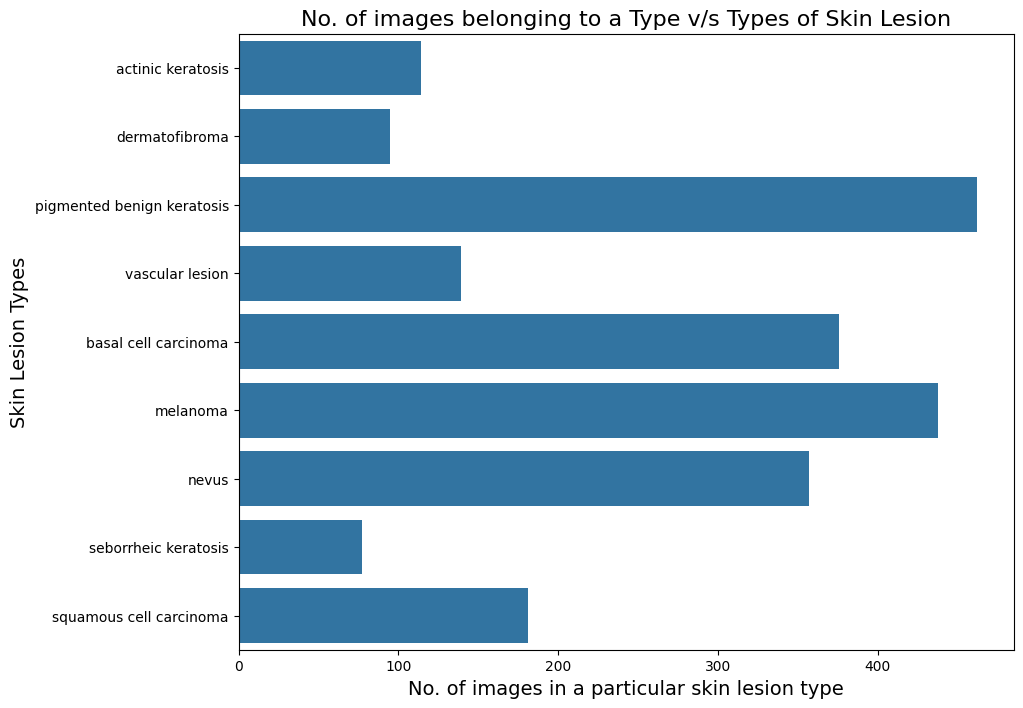

In [33]:
# Visualize the distribution of classes using a countplot
plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data=lesions_df)
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

In [34]:
round(lesions_df[['Label']].value_counts(normalize=True)*100, 2)

,proportion
Label,
pigmented benign keratosis,20.63
melanoma,19.56
basal cell carcinoma,16.79
nevus,15.94
squamous cell carcinoma,8.08
vascular lesion,6.21
actinic keratosis,5.09
dermatofibroma,4.24
seborrheic keratosis,3.44


#### Write your findings here:
#### - Which class has the least number of samples?
"seborrheic keratosis" class has least number of samples with count as 77
#### - Which classes dominate the data in terms proportionate number of samples?
"pigmented benign keratosis" has the highest number of saples with count as 462


***Observations:***

1. A clear class imbalance is evident within the training data.

2. The class **"seborrheic keratosis"** comprises the smallest proportion of samples, accounting for approximately **3.44%**.

3. **"Pigmented benign keratosis"** and **"melanoma"** significantly outweigh other classes, representing approximately **20.63%** and **19.56%** of the data, respectively.

### 8. Handling class imbalances

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [35]:
!pip install Augmentor # install the Augmentor package
import Augmentor
path_to_training_dataset = str(train_dir) + '/'
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/SkinCancer_Data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x786B5C6F3D90>: 100%|██████████| 500/500 [00:04<00:00, 115.69 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/SkinCancer_Data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x786B5C53BD00>: 100%|██████████| 500/500 [00:04<00:00, 110.57 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/SkinCancer_Data/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x786B5C557430>: 100%|██████████| 500/500 [00:04<00:00, 109.48 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/SkinCancer_Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x786B5C60BFA0>: 100%|██████████| 500/500 [00:13<00:00, 35.96 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/SkinCancer_Data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=964x672 at 0x786BD0373790>: 100%|██████████| 500/500 [00:13<00:00, 37.82 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/SkinCancer_Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x786BD0193490>: 100%|██████████| 500/500 [00:04<00:00, 108.43 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/SkinCancer_Data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x786BD022B1F0>: 100%|██████████| 500/500 [00:06<00:00, 73.26 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/SkinCancer_Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x786BD0193490>: 100%|██████████| 500/500 [00:04<00:00, 114.29 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/SkinCancer_Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x786B80306560>: 100%|██████████| 500/500 [00:04<00:00, 108.67 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [36]:
# Verifying the total count of images after the augmentation
image_count_train = len(list(train_dir.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [37]:
# extracting the augmented image paths in a list
path_list_new = [x for x in glob(os.path.join(train_dir, '*','output', '*.jpg'))]
path_list_new[:5]

['/content/drive/MyDrive/Colab Notebooks/SkinCancer_Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032422.jpg_09951079-8433-4afe-909c-860348bec9ea.jpg',
 '/content/drive/MyDrive/Colab Notebooks/SkinCancer_Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030730.jpg_af9f91a2-cb4c-42f9-bfe4-c975b14fa00e.jpg',
 '/content/drive/MyDrive/Colab Notebooks/SkinCancer_Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031506.jpg_d52ab0a5-d3a3-4158-9965-ede1c07184c0.jpg',
 '/content/drive/MyDrive/Colab Notebooks/SkinCancer_Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031040.jpg_271ff9d6-2b4a-4c76-8f93-3a78a3a586a2.jpg',
 '/content/drive/MyDrive/Colab Notebooks/SkinCancer_Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029930.jpg_e6388298-7c51-4146-964e-6d3ab4bcbca0.jpg']

In [38]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(train_dir, '*','output', '*.jpg'))]
lesion_list_new[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [39]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [40]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Image Path','Label'])
# Use pd.concat instead of append to combine the two DataFrames
new_df = pd.concat([lesions_df, df2])
new_df.shape

(6739, 2)

In [41]:
# View the augmented image paths and labels in a new df
new_df.head()

,Image Path,Label
0,/content/drive/MyDrive/Colab Notebooks/SkinCan...,actinic keratosis
1,/content/drive/MyDrive/Colab Notebooks/SkinCan...,actinic keratosis
2,/content/drive/MyDrive/Colab Notebooks/SkinCan...,actinic keratosis
3,/content/drive/MyDrive/Colab Notebooks/SkinCan...,actinic keratosis
4,/content/drive/MyDrive/Colab Notebooks/SkinCan...,actinic keratosis


In [42]:
# Inspecting the classes after adding 500 samples per label
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


In [43]:
# Inspecting the classes (% age wise) after adding 500 samples per label
round(new_df['Label'].value_counts(normalize=True)*100, 2)

,proportion
Label,
pigmented benign keratosis,14.28
melanoma,13.92
basal cell carcinoma,13.00
nevus,12.72
squamous cell carcinoma,10.11
vascular lesion,9.48
actinic keratosis,9.11
dermatofibroma,8.83
seborrheic keratosis,8.56


### 9. Model Building & training on the rectified class imbalance data

In [44]:
batch_size = 32
img_height = 180
img_width = 180

Create a training dataset

In [45]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Create a validation dataset

In [46]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Create your model (make sure to include normalization)

In [48]:
from tensorflow.keras.layers import BatchNormalization

model_3 = Sequential([
  layers.Rescaling(1.0/255),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(128, (3, 3), padding='same', activation=tf.nn.relu),
  BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(256, (3, 3), padding='same', activation=tf.nn.relu),
  BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dropout(0.25),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dropout(0.25),
  layers.Dense(64, activation=tf.nn.relu),
  layers.Dropout(0.25),
  layers.Dense(len(class_names),activation='softmax')
])

Compile your model (Choose optimizer and loss function appropriately)

In [49]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model_3.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### Train your model

In [50]:
%%time
epochs = 30
history = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 32s 127ms/step - accuracy: 0.1787 - loss: 3.4195 - val_accuracy: 0.1448 - val_loss: 2.3195
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.3002 - loss: 1.8959 - val_accuracy: 0.1633 - val_loss: 2.2758
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.3243 - loss: 1.7565 - val_accuracy: 0.2012 - val_loss: 2.3321
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.3609 - loss: 1.6422 - val_accuracy: 0.2702 - val_loss: 1.8606
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.3852 - loss: 1.5759 - val_accuracy: 0.4692 - val_loss: 1.3968
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.4172 - loss: 1.5228 - val_accuracy: 0.3445 - val_loss: 1.8354
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.4164 - loss: 1.5151 - val_accuracy: 0.4647 - val_loss: 1.3668
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.4442 - loss: 1.4269 -

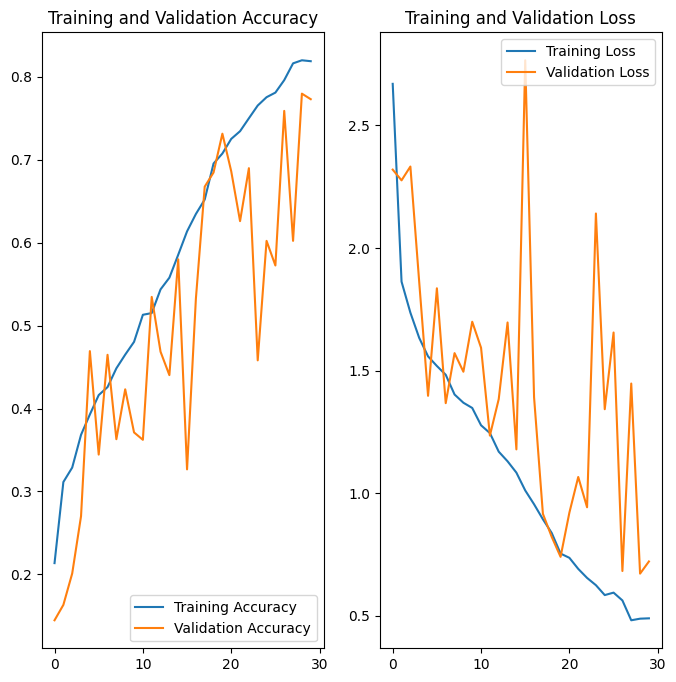

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [52]:
model_accfortrainval(model_3)

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.8482 - loss: 0.3878
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7636 - loss: 0.8290
Accuracy:  0.8557121753692627
Validation Accuracy:  0.7728285193443298
Loss:  0.3729759156703949
Validation Loss 0.7209662795066833


***Observations:***

1. The training accuracy (85.57%) is significantly higher than the validation accuracy (77.28%), which suggests that the model performs well on the training data but struggles to generalize to unseen data.
